# Deep

In this notebook, we will implement a deep neural network.

1. Initialize parameters
2. Forward propagation
3. Compute cost
4. Backward propagation
5. Update parameters
6. Load and preprocess dataset
7. Model
8. Predict

### Utilities

In [1]:
def sigmoid(Z):
    A = 1/(1+np.exp(-Z))
    cache = Z
    return A, cache

def relu(Z):
    A = np.maximum(0,Z)
    cache = Z
    return A, cache

def relu_backward(dA, cache):
    Z = cache
    dZ = np.array(dA, copy=True)
    dZ[Z <= 0] = 0
    return dZ

def sigmoid_backward(dA, cache):
    Z = cache
    s = 1/(1+np.exp(-Z))
    dZ = dA * s * (1-s)
    return dZ

### Initialize parameters

In [2]:
import numpy as np

def initialize_parameters_deep(layer_dims):
    
    np.random.seed(1) # We need random weights to "break the symmetry"
    parameters = {}
    L = len(layer_dims)
    
    for l in range(1, L): # TODO: the square root that we do below is very important. Why?
        parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1]) / np.sqrt(layer_dims[l-1]) #*0.01
        parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))
    
    return parameters

### Forward propagation

In [3]:
def linear_forward(A, W, b): # X can be considered as A[0]
    Z = np.dot(W, A) + b
    cache = (A, W, b)
    return Z, cache

In [4]:
def linear_activation_forward(A_prev, W, b, activation):
    if activation == 'sigmoid':
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = sigmoid(Z)
    
    elif activation == 'relu':
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = relu(Z)
        
    cache = (linear_cache, activation_cache)
    return A, cache

In [5]:
def L_model_forward(X, parameters):
    caches = []
    A = X
    L = len(parameters) // 2 # Every layer has two parameters: W and b
    
    for l in range(1, L):
        A_prev = A
        A, cache = linear_activation_forward(A_prev, parameters['W' + str(l)], parameters['b' + str(l)], activation='relu')
        caches.append(cache) # Cache contains (A,W,b). Used later to calculate (dW, db, dA)
    
    # Only last layer is sigmoid, so we're doing it out of the loop
    AL, cache = linear_activation_forward(A, parameters['W' + str(L)], parameters['b' + str(L)], activation='sigmoid')
    caches.append(cache)
    return AL, caches

### Compute cost

In [6]:
def compute_cost(AL, Y): # We only take the last activation layer for computing the cost
    m = Y.shape[1]
    cost = (1./m) * (-np.dot(Y, np.log(AL).T) - np.dot(1-Y, np.log(1-AL).T)) # TODO: why does it not work with negative sign outside?
    cost = np.squeeze(cost) # Converts [[42]] to 42
    return cost

### Backward propagation

In [7]:
def linear_backward(dZ, cache):
    A_prev, W, b = cache # Cache contains (A, W, b)
    m = A_prev.shape[1]
    
    dW = (1./m) * np.dot(dZ, A_prev.T)
    db = (1./m) * np.sum(dZ, axis=1, keepdims=True) # axis => sum by the rows,  keepdims => leave dimension as 1
    dA_prev = np.dot(W.T, dZ)
    
    return dA_prev, dW, db

In [8]:
def linear_activation_backward(dA, cache, activation):
    
    linear_cache, activation_cache = cache
   
    if activation == 'relu':
        dZ = relu_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
   
    elif activation == 'sigmoid':
        dZ = sigmoid_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
        
    return dA_prev, dW, db

In [9]:
def L_model_backward(AL, Y, caches):
    grads = {}
    L = len(caches)
    m = AL.shape[1]
    Y = Y.reshape(AL.shape)
    
    dAL = -(np.divide(Y, AL) - np.divide(1-Y, 1-AL))

    # This time around, we do the last layer out of the loop since it's sigmoid
    current_cache = caches[L-1]
    grads['dA' + str(L-1)], grads['dW' + str(L)], grads['db' + str(L)] = linear_activation_backward(dAL, current_cache, activation='sigmoid')
    
    for l in reversed(range(L-1)):
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(grads['dA' + str(l+1)], current_cache, activation='relu')
        grads['dA' + str(l)] = dA_prev_temp
        grads['dW' + str(l+1)] = dW_temp
        grads['db' + str(l+1)] = db_temp
        
    return grads

### Update parameters

In [10]:
def update_parameters(params, grads, learning_rate):
    parameters = params.copy() # Always remember to deep copy the weights and biases
    L = len(parameters) // 2

    for l in range(L):
        parameters['W' + str(l+1)] = parameters['W' + str(l+1)] - learning_rate * grads['dW' + str(l+1)]
        parameters['b' + str(l+1)] = parameters['b' + str(l+1)] - learning_rate * grads['db' + str(l+1)]
    
    return parameters

### Load and preprocess the dataset

In [11]:
import h5py

def load_data(): # Same as what we saw in our perceptron notebook
    train_dataset = h5py.File('datasets/train_catvnoncat.h5', 'r')
    train_set_x_orig = np.array(train_dataset['train_set_x'][:])
    train_set_y_orig = np.array(train_dataset['train_set_y'][:])

    test_dataset = h5py.File('datasets/test_catvnoncat.h5', "r")
    test_set_x_orig = np.array(test_dataset['test_set_x'][:])
    test_set_y_orig = np.array(test_dataset['test_set_y'][:])

    classes = np.array(test_dataset['list_classes'][:])
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

1


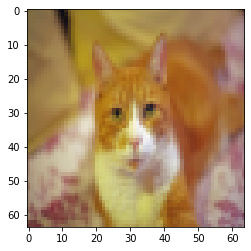

In [12]:
import matplotlib.pyplot as plt

train_x_orig, train_y, test_x_orig, test_y, classes = load_data()
print(train_y[0,24])
plt.imshow(train_x_orig[24])

In [13]:
# Same trick as in perceptron to flatten images
train_x_flatten = train_x_orig.reshape(train_x_orig.shape[0], -1).T
test_x_flatten = test_x_orig.reshape(test_x_orig.shape[0], -1).T

# Also standardize
train_x = train_x_flatten/255
test_x = test_x_flatten/255

### Two layer model

We're building a two-layer model for now, we will build an L-layer model later.

In [14]:
n_x = 12288
n_h = 7
n_y = 1
layers_dims = (n_x, n_h, n_y)
learning_rate = 0.0075

In [15]:
def two_layer_model(X, Y, layers_dims, learning_rate=0.0075, num_iterations=3000):
    np.random.seed(1)
    grads = {}
    costs = []
    m = X.shape[1]
    (n_x, n_h, n_y) = layers_dims
    
    parameters = initialize_parameters_deep([n_x, n_h, n_y])
    
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    
    for i in range(0, num_iterations):
        
        # Forward propagation
        A1, cache1 = linear_activation_forward(X, W1, b1, 'relu')  # TODO: try sigmoid
        A2, cache2 = linear_activation_forward(A1, W2, b2, 'sigmoid')
        cost = compute_cost(A2, Y)
        
        # Backward propagation
        dA2 = - (np.divide(Y, A2) - np.divide(1 - Y, 1 - A2))
        dA1, dW2, db2 = linear_activation_backward(dA2, cache2, 'sigmoid')
        dA0, dW1, db1 = linear_activation_backward(dA1, cache1, 'relu')
        
        grads['dW1'] = dW1
        grads['db1'] = db1
        grads['dW2'] = dW2
        grads['db2'] = db2
        
        # Update parameters
        parameters = update_parameters(parameters, grads, learning_rate)
        
        W1 = parameters["W1"]
        b1 = parameters["b1"]
        W2 = parameters["W2"]
        b2 = parameters["b2"]
        
        # Cost utilities
        # print("Cost after iteration {}: {}".format(i, np.squeeze(cost)))
        costs.append(cost)
    return parameters, costs

def plot_costs(costs, learning_rate=0.0075):
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.title('Learning rate = ' + str(learning_rate))
    plt.show()

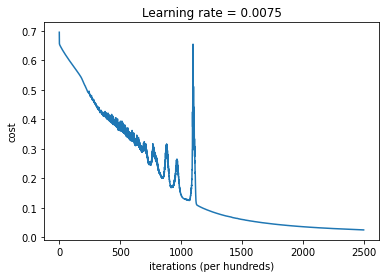

In [16]:
parameters, costs = two_layer_model(train_x, train_y, layers_dims=(n_x, n_h, n_y), num_iterations=2500)
plot_costs(costs, learning_rate)

### Predict

In [17]:
def predict(X, y, parameters):
    m = X.shape[1]
    n = len(parameters) // 2
    p = np.zeros((1,m))
    
    # Forward propagation
    probabilities, caches = L_model_forward(X, parameters)
    
    for i in range(0, probabilities.shape[1]):
        if probabilities[0,i] > 0.5:
            p[0,i] = 1
        else:
            p[0,i] = 0
    
    return np.sum((p == y)/m)

In [18]:
train_preds = predict(train_x, train_y, parameters)
test_preds = predict(test_x, test_y, parameters)
print(train_preds, test_preds)

0.9999999999999998 0.74


### L-layer model

In [19]:
layers_dims = [12288, 20, 7, 5, 1]

In [20]:
def L_layer_model(X, Y, layers_dims, learning_rate=0.0075, num_iterations=3000):
    np.random.seed(1)
    costs = []
    
    parameters = initialize_parameters_deep(layers_dims)
    
    for i in range(0, num_iterations):
        AL, caches = L_model_forward(X, parameters)
        cost = compute_cost(AL, Y)
        grads = L_model_backward(AL, Y, caches)
        parameters = update_parameters(parameters, grads, learning_rate)
        
        #print("Cost after iteration {}: {}".format(i, np.squeeze(cost)))
        costs.append(cost)
    return parameters, costs

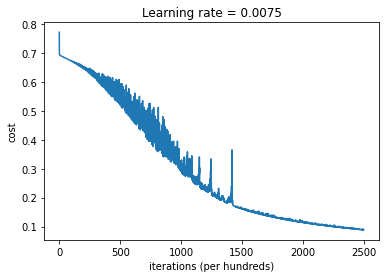

In [21]:
parameters, costs = L_layer_model(train_x, train_y, layers_dims, num_iterations=2500)
plot_costs(costs, learning_rate)

### Predict

In [22]:
train_preds = predict(train_x, train_y, parameters)
test_preds = predict(test_x, test_y, parameters)
print(train_preds, test_preds)

0.9856459330143539 0.8
